Download colab_utils and import



<a href="https://colab.research.google.com/github/beangoben/gnn_workshop_riiaa/blob/master/Prediccion de Nodos con Arxiv MAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [ ]:
!wget https://raw.githubusercontent.com/beangoben/workshop_template/master/colab_utils.py -O colab_utils.py
!rm -rf sample_data
import colab_utils

--2020-08-25 22:17:48--  https://raw.githubusercontent.com/beangoben/workshop_template/master/colab_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7173 (7.0K) [text/plain]
Saving to: ‘colab_utils.py’

colab_utils.py      100%[===================>]   7.00K  --.-KB/s    in 0s      

2020-08-25 22:17:48 (43.1 MB/s) - ‘colab_utils.py’ saved [7173/7173]



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Clone github repo, install stuff

In [ ]:
github_repo = 'https://github.com/beangoben/gnn_workshop_riiaa'
colab_utils.clone_repo(github_repo)
colab_utils.conda_install_from_yaml()
colab_utils.pip_install_from_yaml()

CMD: git clone --recursive https://github.com/beangoben/gnn_workshop_riiaa
Conda installing ['rdkit']
 from channels ['rdkit', 'conda-forge']
CMD: wget -c https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
CMD: chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
CMD: bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
PREFIX=/usr/local
Unpacking payload ...
Solving environment: ...working... done
## Package Plan ##
environment location: /usr/local
added / updated specs:
- _libgcc_mutex==0.1=main
- ca-certificates==2020.1.1=0
- certifi==2020.4.5.1=py37_0
- cffi==1.14.0=py37he30daa8_1
- chardet==3.0.4=py37_1003
- conda-package-handling==1.6.1=py37h7b6447c_0
- conda==4.8.3=py37_0
- cryptography==2.9.2=py37h1ba5d50_0
- idna==2.9=py_1
- ld_impl_linux-64==2.33.1=h53a641e_7
- libedit==3.1.20181209=hc058e9b_0
- libffi==3.3=he6710b0_1
- libgcc-ng==9.1.0=hdf63c60_0
- libstdcxx-ng==9.1.0=hdf63c60_0
- ncurses==6.2=he6710b0_1
- openssl==1.1.1g=h7b6447c_0
- pip==20.0.2

# Import modules


In [ ]:
import os
from collections import OrderedDict, defaultdict

import tqdm.auto as tqdm
import colab_utils 
colab_utils.add_conda_dir_to_python_path()

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import networkx as nx

import sklearn
import umap
import tensorflow as tf
import sonnet as snt
import graph_nets as gn

import rdkit
import rdkit.Chem
import rdkit.Chem.AllChem as Chem
from rdkit.Chem import AllChem, Draw
import rdkit.Chem.rdFingerprintGenerator as rdFP
from rdkit.Chem.Draw import IPythonConsole

colab_utils.print_module_versions([umap, tf, snt, nx, rdkit])
print(f'Tiene GPU? {tf.config.list_physical_devices("gpu")}')
colab_utils.matplotlib_settings()

umap      : 0.4.6
tensorflow: 2.3.0
sonnet    : 2.0.0
networkx  : 2.4
rdkit     : 2020.03.5
Tiene GPU? []


## Lodear dataset (grafos moleculares)

In [ ]:
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

--2020-08-25 22:29:06--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.008s  

2020-08-25 22:29:07 (11.4 MB/s) - ‘delaney-processed.csv’ saved [96699/96699]



In [ ]:
df = pd.read_csv('delaney-processed.csv')
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
print(df.shape)
print(df.columns)
df.head()

(1128, 11)
Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
       'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
       'measured log solubility in mols per litre', 'smiles', 'mol'],
      dtype='object')


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,mol
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7f1341c9c1c0>
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x7f1341cdcb70>
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x7f1341cc0cb0>
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x7f1341cc0c10>
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x7f1341cc0ad0>


# Visualizar los grafos

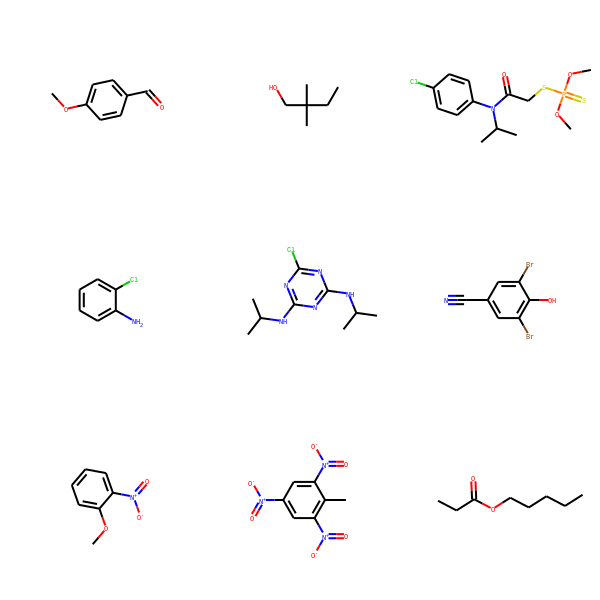

In [ ]:
mols = df['mol'].sample(n=9).tolist()
Draw.MolsToGridImage(mols)

## Construir train-test split

In [ ]:
indices = np.array(df.index)
mols = np.array(df['mol'].tolist())
train_index, test_index = sklearn.model_selection.train_test_split(indices, test_size=.20)
mols_train, mols_test = mols[train_index], mols[test_index]
print(len(train_index),len(test_index))

902 226


## Propiedad de interes

In [ ]:
target = "measured log solubility in mols per litre"
y_true = df[target].values.reshape(-1,1).astype(np.float32)
y_train = y_true[train_index]
y_test = y_true[test_index]
print(y_train.shape, y_test.shape)

(902, 1) (226, 1)


## Un baseline (atribucion en 1-D) con modelos lineales

In [ ]:
fps =  [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) for m in mols]
fps = np.vstack(np.array(fps))
fps_train, fps_test = fps[train_index], fps[test_index]
fps.shape

(1128, 2048)

## Mol a grafo

In [ ]:
from rdkit import Chem
import numpy as np


possible_atom_list = ['S', 'Si', 'F', 'O',
                      'C', 'I', 'P', 'Cl', 'Br', 'N', 'Unknown']


reference_lists = [
    possible_atom_list
]


def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


def safe_index(l, e):
    """Gets the index of e in l, providing an index of len(l) if not found"""
    try:
        return l.index(e)
    except:
        return len(l)


def get_feature_list(atom):
    features[safe_index(possible_atom_list, atom.GetSymbol())]
    return features

def atom_features(atom):
    results = one_of_k_encoding_unk(atom.GetSymbol(), possible_atom_list)
    return np.array(results).astype(np.float32)


def bond_features(bond):
    bt = bond.GetBondType()
    bond_feats = [
        bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC]
    return np.array(bond_feats).astype(np.float32)


def get_bond_pair(mol):
    bonds = mol.GetBonds()
    res = [[], []]
    n_atoms = mol.GetNumAtoms()
    adj = np.zeros((n_atoms,n_atoms))
    for bond in bonds:
        res[0] += [bond.GetBeginAtomIdx()]
        res[1] += [bond.GetEndAtomIdx()]
        adj[bond.GetBeginAtomIdx(),bond.GetEndAtomIdx()]=1
        adj[bond.GetEndAtomIdx(),bond.GetBeginAtomIdx()]=1

    return res, adj


def mol2graph_data(mol):
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()
    node_f = [atom_features(atom) for atom in atoms]
    edge_index, adj = get_bond_pair(mol)
    edge_f = [bond_features(bond) for bond in bonds]
    return np.stack(node_f),np.stack(edge_index).T,np.stack(edge_f), adj


def n_atom_features():
    atom = Chem.MolFromSmiles('C').GetAtomWithIdx(0)
    return len(atom_features(atom))


def n_bond_features():
    bond = Chem.MolFromSmiles('CC').GetBondWithIdx(0)
    return len(bond_features(bond))

In [ ]:
def mol_to_datatdict(mol):
  mol = df['mol'].iloc[0]
  nodes = np.array([atom_features(atom) for atom in mol.GetAtoms()])
  edges = []
  for bond in mol.GetBonds():
    edges.append(bond_features(bond))
    edges.append(bond_features(bond))
  edges = np.array(edges)
  senders = []
  receivers = []
  for bond in mol.GetBonds():
    senders.extend([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
    receivers.extend([bond.GetEndAtomIdx(),bond.GetBeginAtomIdx()])

  data_dict = {'nodes':nodes.astype(np.float32), 'edges':edges.astype(np.float32),
              'globals':np.array([0]).astype(np.float32),
              'senders':np.array(senders),
              'receivers':np.array(receivers)}
  return data_dict

data_dict_train = [mol_to_datatdict(mol) for mol in mols_train]
data_dict_test = [mol_to_datatdict(mol) for mol in mols_test]

x_train = gn.utils_tf.data_dicts_to_graphs_tuple(data_dict_train)
x_test = gn.utils_tf.data_dicts_to_graphs_tuple(data_dict_test)

# Armar un GNN para regression

In [ ]:
def get_num_parameters(model: snt.Module, trainable: bool = True) -> int:
  """Numero de parametros."""
  variables = model.trainable_variables if trainable else model.variables
  return int(np.sum([np.prod(v.shape) for v in variables]))


def print_model(model: snt.Module):
  """Sumario de un modelo."""
  print(f'{model.__class__.__name__} : {model.name}\n')
  print(snt.format_variables(model.variables))
  n_params = get_num_parameters(model, False)
  trainable_params = get_num_parameters(model, True)
  print(f'\nParams: {trainable_params} trainable out of {n_params}')

## Bloque de transformacion

In [ ]:
def make_mlp_model(latent_size=32, n_layers=2, add_head=0):
    """Crea un MLP luego pasando por un LayerNorm y opcionalmente una capa lineal."""
    layers = [
        snt.nets.MLP([latent_size] * n_layers, activate_final=True),
        snt.LayerNorm(axis=-1, create_offset=True, create_scale=True)]
    if add_head > 0:
        layers.append(snt.Linear(add_head))
    return snt.Sequential(layers)
    
bloque = make_mlp_model(32, 2, 0)
bloque(x_train.nodes)
print_model(bloque)

Sequential : sequential

| Variable          | Spec       | Trainable   | Device   |
|-------------------+------------+-------------+----------|
| layer_norm/offset | f32[32]    | True        | GPU      |
| layer_norm/scale  | f32[32]    | True        | GPU      |
| mlp/linear_0/w    | f32[11,32] | True        | GPU      |
| mlp/linear_0/b    | f32[32]    | True        | GPU      |
| mlp/linear_1/w    | f32[32,32] | True        | GPU      |
| mlp/linear_1/b    | f32[32]    | True        | GPU      |

Params: 1504 trainable out of 1504


## GNN: GraphNets

In [ ]:
cabeza = gn.modules.GraphIndependent(node_model_fn=lambda: snt.Linear(1))

gnn_layers = [gn.modules.GraphNetwork(
    edge_model_fn=lambda: make_mlp_model(32, 2),
    node_model_fn=lambda: make_mlp_model(32, 2),
    global_model_fn=lambda: make_mlp_model(32, 2)) for i in range(3)]

gnn = snt.Sequential( gnn_layers + [cabeza])
out = gnn(x_train)
print_model(gnn)

Sequential : sequential

| Variable                                     | Spec        | Trainable   | Device   |
|----------------------------------------------+-------------+-------------+----------|
| graph_independent/node_model/linear/w        | f32[32,1]   | True        | GPU      |
| graph_independent/node_model/linear/b        | f32[1]      | True        | GPU      |
| graph_network/edge_block/layer_norm/offset   | f32[32]     | True        | GPU      |
| graph_network/edge_block/layer_norm/offset   | f32[32]     | True        | GPU      |
| graph_network/edge_block/layer_norm/offset   | f32[32]     | True        | GPU      |
| graph_network/edge_block/layer_norm/scale    | f32[32]     | True        | GPU      |
| graph_network/edge_block/layer_norm/scale    | f32[32]     | True        | GPU      |
| graph_network/edge_block/layer_norm/scale    | f32[32]     | True        | GPU      |
| graph_network/edge_block/mlp/linear_0/w      | f32[27,32]  | True        | GPU      |
| graph

In [ ]:
NUM_ITER = 100
optimizer = tf.optimizers.Adam(3e-4)
metric = tf.keras.metrics.MeanAbsoluteError()
loss_fn = tf.keras.losses.MeanSquaredError()

In [ ]:
@tf.function(experimental_relax_shapes=True)
def forward_pass(x):
    """Prediccion."""
    out_x = gnn(x)
    return out_x.globals

def calc_stats(y_true, y_pred, prefix):
    """Conseguir estadisticas"""
    return {f'{prefix}_loss':loss_fn(y_true, y_pred).numpy(), 
            f'{prefix}_MAE':metric(y_true, y_pred).numpy()}

In [ ]:
pbar = tqdm.tqdm(range(NUM_ITER))
stats = []

for i in pbar:
    with tf.GradientTape() as tape:
      y_pred = forward_pass(x_train)
      loss = loss_fn(y_train, y_pred)
    grads = tape.gradient(loss, gnn.trainable_variables)
    optimizer.apply_gradients((grad, var) 
    for (grad, var) in zip(grads, gnn.trainable_variables) 
    if grad is not None)
    # Train statistics.
    y_pred =  gnn(x_train).globals
    stat = calc_stats(y_train, y_pred , 'train')
    # Test statistics.
    y_pred =  gnn(x_test).globals
    stat.update(calc_stats(y_test, y_pred, 'test'))
    stats.append(stat)
    # Update progress bar.
    pbar.set_postfix(stats[-1])

In [ ]:
train_df = pd.DataFrame(stats)
train_df

,train_loss,train_MAE,test_loss,test_MAE
0,22647.898438,3155.847168,22649.396484,3149.906250
1,16476.103516,3126.206299,16480.042969,3120.326172
2,8286.666016,3096.861816,8288.919922,3091.039307
3,5801.845703,3068.001221,5801.723633,3062.284180
4,6183.797852,3039.665527,6183.541016,3034.052002
...,...,...,...,...
95,5.130070,1641.799561,5.232236,1640.131592
96,5.333083,1633.508179,5.439906,1631.857178
97,4.929146,1625.300171,4.935478,1623.665649
98,4.726124,1617.174316,4.601005,1615.556030


No handles with labels found to put in legend.


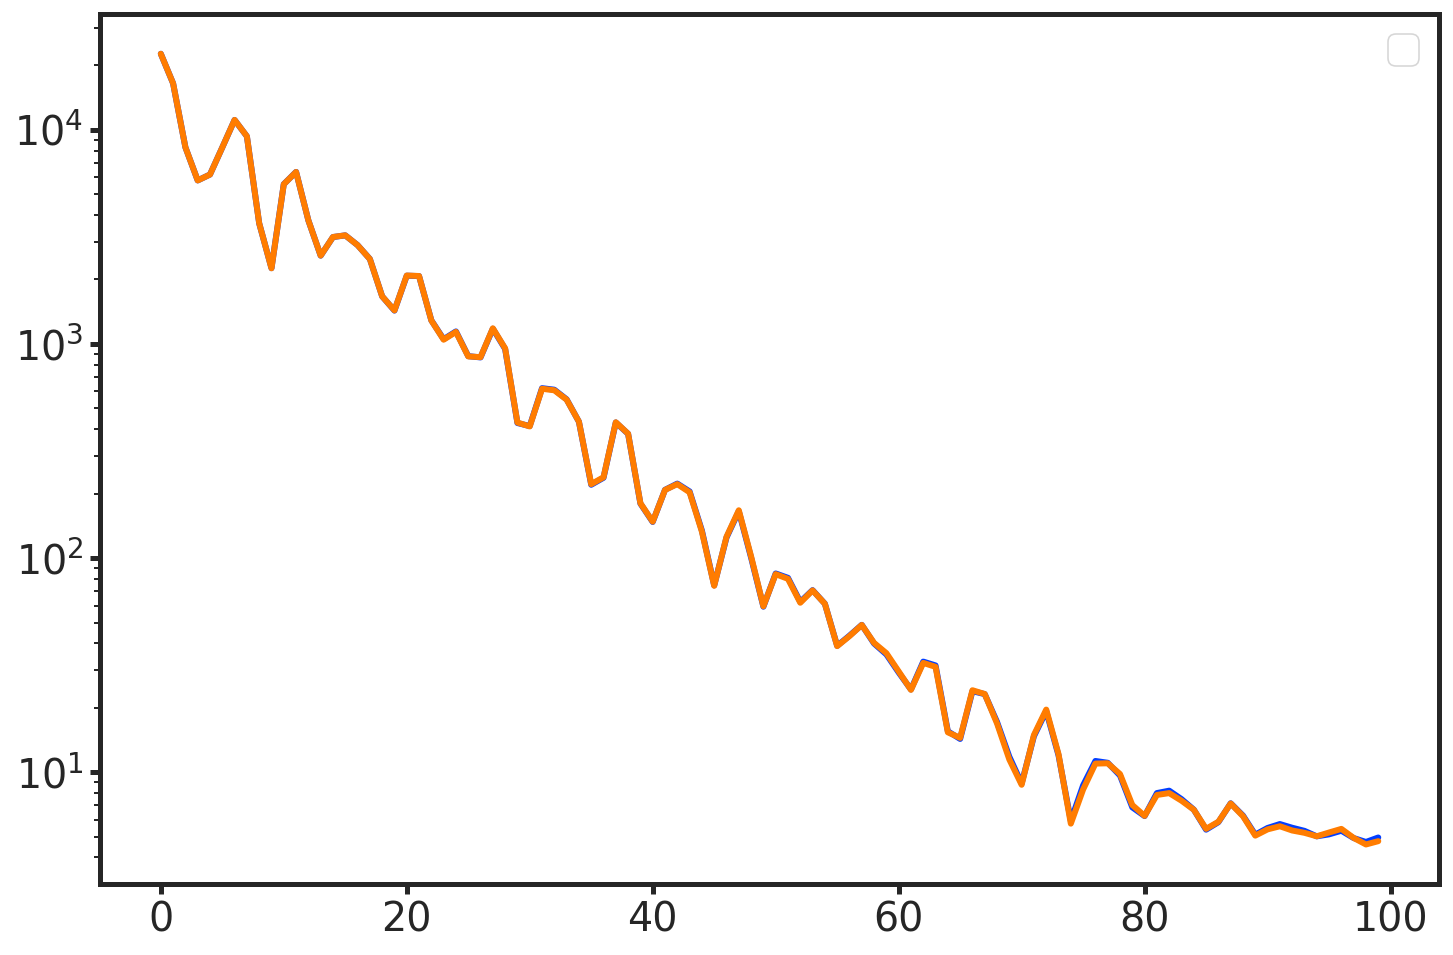

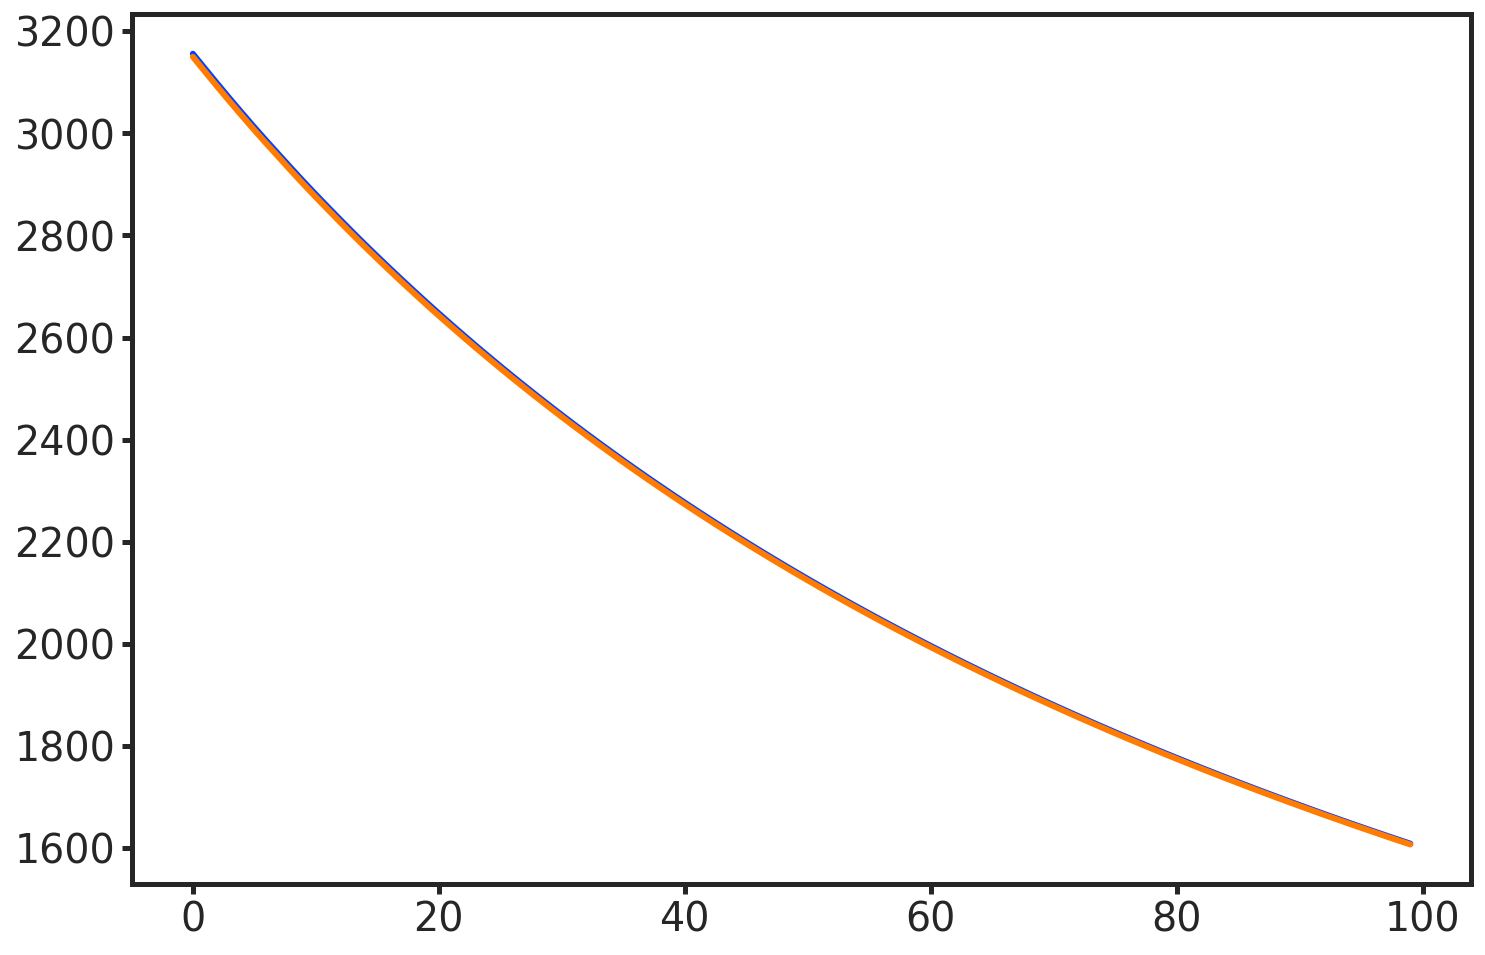

In [ ]:
for key in ['train_loss','test_loss']:
    plt.plot(train_df[key])
plt.yscale('log')
plt.legend()
plt.show()

for key in ['train_MAE','test_MAE']:
    plt.plot(train_df[key])
plt.show()

# Conseguir gradient

In [ ]:
def calc_gradient(x):
  with tf.GradientTape(watch_accessed_variables=False) as gtape:
    gtape.watch([x.nodes, x.edges])
    y = forward_pass(x)
  nodes_grad, edges_grad = gtape.gradient(y, [x.nodes, x.edges])
  return  nodes_grad, edges_grad

calc_gradient(x_train)

(<tf.Tensor: shape=(28864, 11), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(61336, 4), dtype=float32, numpy=
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], dtype=float32)>)